# Sentiment Analysis on Amazon Food Reviews Dataset

Author: Karanveer Lamba

Submission Date: 5th August 2024

In [1]:
# Imports for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
Lemmatizer = WordNetLemmatizer()
stemmer = nltk.SnowballStemmer("english")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Import transformers
import transformers
import torch


nltk.download('wordnet', download_dir=".")

from wordcloud import STOPWORDS
from collections import Counter
import tensorflow as tf

import pickle as pkl

[nltk_data] Downloading package wordnet to ....
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df_kaggle = pd.read_csv('Reviews.csv')

# Display the first few rows
df_kaggle.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Using Pre-Trained Transformer

In [3]:
# Pull data from the pickle file
# Path to the pickle file
pickle_file_path = 'transformer_preprocessed_data.pkl'

# Open the pickle file in binary read mode
with open(pickle_file_path, 'rb') as file:
    df = pkl.load(file)

In [4]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,positive
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,negative
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",neutral
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,positive


## Pre-processing the data

In [5]:
# Find null values
df[['Text','Score', 'Sentiment']].isnull().sum()

Text         0
Score        0
Sentiment    0
dtype: int64

In [6]:
# We are treating the Text column as the feature variable and score as the target variable
df = df[['Score', 'Text', 'Sentiment']]

df.head()

,Score,Text,Sentiment
0,5,I have bought several of the Vitality canned d...,positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,4,This is a confection that has been around a fe...,positive
3,2,If you are looking for the secret ingredient i...,positive
4,5,Great taffy at a great price. There was a wid...,positive


In [7]:
# Keeping only the first of any duplicates
df.drop_duplicates(subset=['Text','Score','Sentiment'],keep='first',inplace=True) 

/var/folders/yf/wjmrp9xs1rn2rmmhttv8wjt80000gn/T/ipykernel_44091/1109385273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['Text','Score','Sentiment'],keep='first',inplace=True)


In [8]:
df.shape

(393675, 3)

In [9]:
# Create a copy of the dataframe for preprocessing and further EDA
df_reviews = df.copy()

In [10]:
df_reviews

,Score,Text,Sentiment
0,5,I have bought several of the Vitality canned d...,positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,4,This is a confection that has been around a fe...,positive
3,2,If you are looking for the secret ingredient i...,positive
4,5,Great taffy at a great price. There was a wid...,positive
...,...,...,...
568449,5,Great for sesame chicken..this is a good if no...,positive
568450,2,I'm disappointed with the flavor. The chocolat...,negative
568451,5,"These stars are small, so you can give 10-15 o...",neutral
568452,5,These are the BEST treats for training and rew...,positive


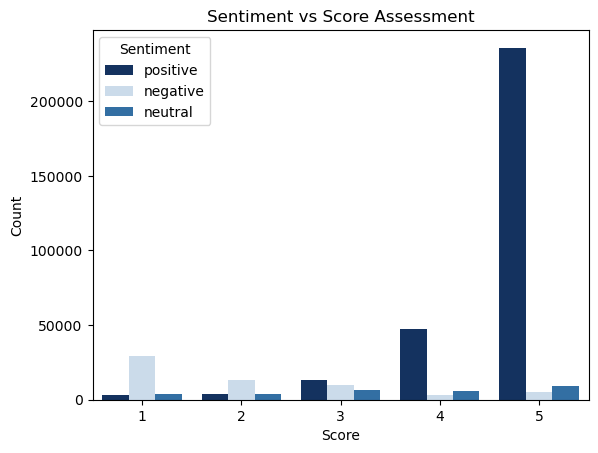

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = {
    'positive': '#08306b',  # Darkest blue
    'neutral': '#2171b5',   # Slightly less blue
    'negative': '#c6dbef'   # Very light blue
}

sns.countplot(data=df_reviews, x='Score', hue='Sentiment', palette=custom_palette)

plt.title("Sentiment vs Score Assessment")
plt.ylabel("Count")
plt.show()

In [12]:
# Drop all neutrally scored reviews
df_reviews = df_reviews[df_reviews['Sentiment']!='neutral']
df_reviews = df_reviews[df_reviews['Score']!=3]

# Drop all conflicting reviews

df_reviews = df_reviews[~((df_reviews['Score'] >= 4) & (df_reviews['Sentiment'] != 'positive'))]
df_reviews = df_reviews[~((df_reviews['Score'] <= 2) & (df_reviews['Sentiment'] != 'negative'))]

In [13]:
# Data loss
((df_reviews.shape[0] - df.shape[0]) / df.shape[0]) *100

-17.281513939163016

In [14]:
df_reviews.shape

(325642, 3)

In [15]:
# Expansion of english contractions
def contraction_expansion(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"needn\'t", "need not", content)
    content = re.sub(r"hasn\'t", "has not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"mightn\'t", "might not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"n\'t", " not", content)
    return content

In [16]:
# Clean dataset
# Function to clean up the texts and get the stemmed version of words
# Stemming: Running -> Run, preprocessing -> process

def clean(text):
    text=str(text).lower()
     # Remove text within square brackets
    text=re.sub('\[.*?\]','',text)
    # Remove URLs
    text=re.sub('https?://\S+|www\.\S+','',text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #  Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters with spaces
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
    # Remove special chartacters
    text = re.sub('\W+', ' ', text)
    # Expand defined contractions
    text = contraction_expansion(text)
     # Tokenize the text and remove stopwords
    text = [word for word in text.split(' ') if word not in STOPWORDS]
    text=" ".join(text)
    # Stem the remaining words
    text = [stemmer.stem(word) for word in text.split(' ')]
    # Join the cleaned and stemmed words back into a string
    text=" ".join(text)
    return text

df_reviews['Text'] = df_reviews["Text"].apply(clean)

## Exploratory Data Analysis (EDA)

In [17]:
# Drop neutral reviews
df_reviews = df_reviews[df_reviews['Score'] != 3]

In [18]:
# Convert the score column into a binary label
def group(score):
    if score > 3:
        return 1
    elif score <= 3:
        return 0

df_reviews['Score'] = df_reviews['Score'].apply(group)

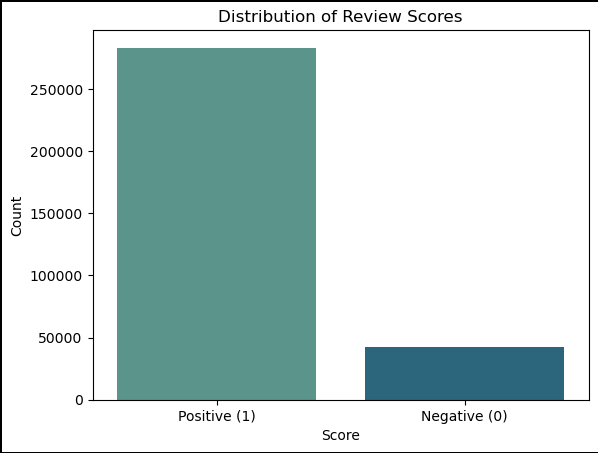

In [83]:
# Assess class imbalance
sns.countplot(x=df_reviews['Score'].map({0:"Negative (0)", 1:"Positive (1)"}), palette='crest') # The classes are imbalanced in favor of positive reviews
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Count')

# Add outer border to the entire figure
fig = plt.gcf()
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(2)
    
plt.show()

/Users/karanveer_lamba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karanveer_lamba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


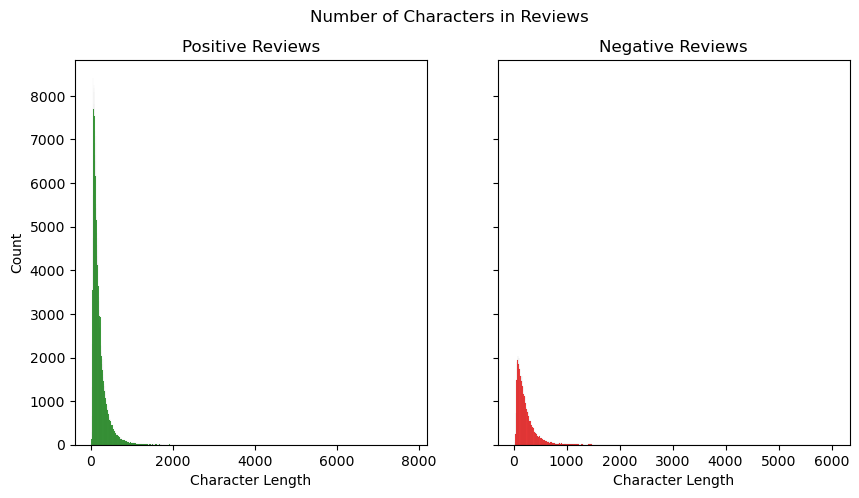

In [20]:
# Plotting review length for positive and negative reviews
figure, (pos_ax, neg_ax) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Extract lengths of positive and negative reviews
len_pos_rev = df_reviews[df_reviews['Score'] == 1]['Text'].str.len()
len_neg_rev = df_reviews[df_reviews['Score'] == 0]['Text'].str.len()

# Plot histograms using seaborn
sns.histplot(len_pos_rev, color='green', ax=pos_ax, kde=False)
pos_ax.set_title('Positive Reviews')
pos_ax.set_xlabel('Character Length')

sns.histplot(len_neg_rev, color='red', ax=neg_ax, kde=False)
neg_ax.set_title('Negative Reviews')
neg_ax.set_xlabel('Character Length')

figure.suptitle("Number of Characters in Reviews")

# Show the plot
plt.show()


/Users/karanveer_lamba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karanveer_lamba/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


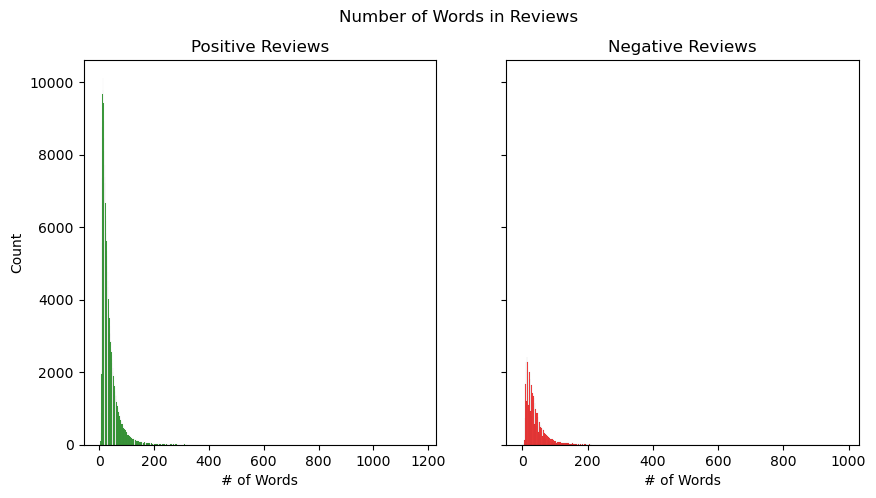

In [21]:
# Plotting number of words for positive and negative reviews
figure, (pos_ax, neg_ax) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Extract lengths of positive and negative reviews
pos_words = df_reviews[df_reviews['Score'] == 1]['Text'].str.split().map(lambda review: len(review))
neg_words = df_reviews[df_reviews['Score'] == 0]['Text'].str.split().map(lambda review: len(review))

# Plot histograms using seaborn
sns.histplot(pos_words, color='green', ax=pos_ax, kde=False)
pos_ax.set_title('Positive Reviews')
pos_ax.set_xlabel('# of Words')

sns.histplot(neg_words, color='red', ax=neg_ax, kde=False)
neg_ax.set_title('Negative Reviews')
neg_ax.set_xlabel('# of Words')

figure.suptitle("Number of Words in Reviews")

# Show the plot
plt.show()

In [22]:
# Run some descriptive stats for positive and negative words
pos_desribe = pd.Series(pos_words, name='pos_reviews').describe()
neg_desribe = pd.Series(neg_words, name='neg_reviews').describe()

pd.concat([pos_desribe, neg_desribe], axis=1)

,pos_reviews,neg_reviews
count,283098.000000,42544.000000
mean,35.725279,38.128220
std,32.781437,33.876571
min,1.000000,0.000000
25%,16.000000,17.000000
50%,26.000000,29.000000
75%,44.000000,47.000000
max,1170.000000,982.000000


In [23]:
# Assign text to array
text = df_reviews['Text'].values

text

array(['bought sever vital can dog food product found good qualiti product look stew process meat smell better labrador finicki appreci product better',
       'product arriv label jumbo salt peanutsth peanut actual small size unsalt sure error vendor intend repres product jumbo',
       'confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori cs lewi lion witch wardrob treat seduc edmund sell brother sister witch',
       ...,
       'im disappoint flavor chocol note especi weak milk thicken flavor still disappoint worth tri ill never buy will use what left will gone time thank small can',
       'best treat train reward dog good groom lower calori love doggi sweet potato seem favorit wet nose treat',
       'satisfi product advertis use cereal raw vinegar general sweetner'],
      dtype=object)

## Tokenization

In [24]:
# Get vocab size for embedding layers later on

tokens = []

for sentence in text:
    
    tokens.extend(sentence.split())
    
word_count = {}

for token in tokens:
    
    if token in word_count:
    
        word_count[token] += 1
    
    else:
    
        word_count[token] = 1
        
vocab_size = len(word_count)

print("Vocabulary size:", vocab_size)

Vocabulary size: 207657


In [25]:
# Initiate tokenization (convert words into numerical values)
tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(text)

sequences = tokenizer.texts_to_sequences(text)

In [26]:
# Pad the sequences
padded_sequences = pad_sequences(sequences, padding='post', truncating='post')

padded_sequences

array([[  60,  191, 3074, ...,    0,    0,    0],
       [   7,  173,  450, ...,    0,    0,    0],
       [3710,  195, 3980, ...,    0,    0,    0],
       ...,
       [  34,  197,    3, ...,    0,    0,    0],
       [  25,   58,  822, ...,    0,    0,    0],
       [ 295,    7,  879, ...,    0,    0,    0]], dtype=int32)

In [27]:
padded_sequences.shape

(325642, 1026)

In [28]:
# Splitting data into training, validation, and test datasets
labels = np.asarray(df_reviews['Score'])

# Parameters
TEST_SIZE = 0.2  # 20% of data will be used for testing
VALIDATION_SIZE = 0.25  # 25% of remaining data will be used for validation (20% of 80% is 20%)

# Split data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, random_state=42)

# Further split training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VALIDATION_SIZE, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (195384, 1026)
Validation data shape: (65129, 1026)
Test data shape: (65129, 1026)


## Model Building

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Baseline Models

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict the sentiments for the test set
y_pred = rf_model.predict(X_val)

In [31]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

# Print classification report
print(classification_report(y_val, y_pred, target_names=['negative', 'positive']))

Validation Accuracy: 0.87
              precision    recall  f1-score   support

    negative       0.90      0.00      0.01      8471
    positive       0.87      1.00      0.93     56658

    accuracy                           0.87     65129
   macro avg       0.89      0.50      0.47     65129
weighted avg       0.87      0.87      0.81     65129



In [32]:
# Logistic Regression Model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_val)
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {accuracy_log_reg:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_log_reg, target_names=['negative', 'positive']))

Logistic Regression Accuracy: 0.87
Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.22      0.00      0.00      8471
    positive       0.87      1.00      0.93     56658

    accuracy                           0.87     65129
   macro avg       0.54      0.50      0.47     65129
weighted avg       0.78      0.87      0.81     65129



/Users/karanveer_lamba/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_val)
accuracy_dt = accuracy_score(y_val, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_val, y_pred_dt, target_names=['negative', 'positive']))

Decision Tree Accuracy: 0.78
Decision Tree Classification Report:
              precision    recall  f1-score   support

    negative       0.18      0.21      0.20      8471
    positive       0.88      0.86      0.87     56658

    accuracy                           0.78     65129
   macro avg       0.53      0.54      0.53     65129
weighted avg       0.79      0.78      0.78     65129



In [34]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)

Trial 13 Complete [00h 38m 55s]
val_accuracy: 0.9441185891628265

Best val_accuracy So Far: 0.9564709961414337
Total elapsed time: 20h 22m 52s


Value             |Best Value So Far |Hyperparameter
128               |128               |filters
3                 |5                 |kernel_size
192               |192               |units
0.2               |0.3               |dropout
0.00077456        |0.0003062         |learning_rate

## Hyperparameter Tuning

In [43]:
import optuna
from sklearn.utils.class_weight import compute_class_weight

def objective(trial):
    VOCAB_SIZE = vocab_size  # You can adjust this based on your dataset

    # Suggest hyperparameters
    embedding_dim = trial.suggest_int('embedding_dim', 50, 300)
    conv_filters = trial.suggest_int('conv_filters', 32, 256)
    kernel_size = trial.suggest_int('kernel_size', 3, 7)
    dense_units = trial.suggest_int('dense_units', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Model Architecture
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=5, 
                        batch_size=128, 
                        validation_data=(X_val, y_val), 
                        class_weight=class_weights,
                        callbacks=[early_stopping],
                        verbose=0)

    # Get the best validation accuracy of the epoch
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)


[I 2024-08-05 08:28:32,290] A new study created in memory with name: no-name-ffb6b3a6-b3ac-4937-86a1-df63bb5e9202
/var/folders/yf/wjmrp9xs1rn2rmmhttv8wjt80000gn/T/ipykernel_44091/390008084.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-08-05 08:55:10,335] Trial 0 finished with value: 0.9451550245285034 and parameters: {'embedding_dim': 127, 'conv_filters': 148, 'kernel_size': 5, 'dense_units': 196, 'dropout_rate': 0.2099949299833075, 'learning_rate': 0.00012645637086228025}. Best is trial 0 with value: 0.9451550245285034.
/var/folders/yf/wjmrp9xs1rn2rmmhttv8wjt80000gn/T/ipykernel_44091/390008084.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

Best hyperparameters:  {'embedding_dim': 212, 'conv_filters': 225, 'kernel_size': 5, 'dense_units': 160, 'dropout_rate': 0.2532190218019172, 'learning_rate': 0.00023328075189033595}


In [51]:
# Save the study to a pickle file
with open('optuna_study.pkl', 'wb') as f:
    pkl.dump(study, f)

In [47]:
study.best_trial

FrozenTrial(number=5, state=1, values=[0.9579603672027588], datetime_start=datetime.datetime(2024, 8, 5, 12, 52, 4, 728702), datetime_complete=datetime.datetime(2024, 8, 5, 13, 47, 24, 906534), params={'embedding_dim': 212, 'conv_filters': 225, 'kernel_size': 5, 'dense_units': 160, 'dropout_rate': 0.2532190218019172, 'learning_rate': 0.00023328075189033595}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'embedding_dim': IntDistribution(high=300, log=False, low=50, step=1), 'conv_filters': IntDistribution(high=256, log=False, low=32, step=1), 'kernel_size': IntDistribution(high=7, log=False, low=3, step=1), 'dense_units': IntDistribution(high=256, log=False, low=32, step=1), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=5, value=None)

In [46]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_conv_filters,params_dense_units,params_dropout_rate,params_embedding_dim,params_kernel_size,params_learning_rate,state
0,0,0.945155,2024-08-05 08:28:32.291933,2024-08-05 08:55:10.335677,0 days 00:26:38.043744,148,196,0.209995,127,5,0.000126,COMPLETE
1,1,0.952371,2024-08-05 08:55:10.336185,2024-08-05 09:31:08.762938,0 days 00:35:58.426753,210,107,0.107312,131,7,0.002372,COMPLETE
2,2,0.952679,2024-08-05 09:31:08.763451,2024-08-05 10:23:14.779460,0 days 00:52:06.016009,206,221,0.408445,251,4,0.000211,COMPLETE
3,3,0.932242,2024-08-05 10:23:14.780096,2024-08-05 12:14:32.547840,0 days 01:51:17.767744,153,142,0.399488,180,7,0.000059,COMPLETE
4,4,0.957239,2024-08-05 12:14:32.556185,2024-08-05 12:52:04.728213,0 days 00:37:32.172028,153,81,0.495601,181,5,0.000601,COMPLETE
5,5,0.957960,2024-08-05 12:52:04.728702,2024-08-05 13:47:24.906534,0 days 00:55:20.177832,225,160,0.253219,212,5,0.000233,COMPLETE
6,6,0.892628,2024-08-05 13:47:24.906975,2024-08-05 14:35:14.293467,0 days 00:47:49.386492,196,147,0.442177,149,7,0.000010,COMPLETE
7,7,0.950544,2024-08-05 14:35:14.293938,2024-08-05 14:52:27.646223,0 days 00:17:13.352285,133,147,0.175476,94,4,0.000176,COMPLETE
8,8,0.891968,2024-08-05 14:52:27.646708,2024-08-05 15:20:59.949061,0 days 00:28:32.302353,51,143,0.399544,255,5,0.000012,COMPLETE
9,9,0.947059,2024-08-05 15:20:59.949560,2024-08-05 15:40:58.970607,0 days 00:19:59.021047,47,42,0.263785,234,3,0.000945,COMPLETE


In [50]:
import optuna.visualization as vis

# Plot optimization history
fig = vis.plot_optimization_history(study)
fig.show()

In [93]:
best_params = study.best_params
best_params

{'embedding_dim': 212,
 'conv_filters': 225,
 'kernel_size': 5,
 'dense_units': 160,
 'dropout_rate': 0.2532190218019172,
 'learning_rate': 0.00023328075189033595}

## Final Model Development

In [55]:
# Configure a basic model with randomly selected paramerers
VOCAB_SIZE = vocab_size

# Model Architecture
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=best_params['embedding_dim']))

model.add(Conv1D(filters=best_params['conv_filters'], kernel_size=best_params['kernel_size'], activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(best_params['dense_units'], activation='relu'))
model.add(Dropout(best_params['dropout_rate']))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Print class weights
print("Class weights:", class_weights)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_data=(X_val, y_val), 
                    class_weight=class_weights,
                    callbacks=[early_stopping])

model.summary()

Class weights: {0: 3.8217666849229324, 1: 0.5752611557984242}
Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 740s 484ms/step - accuracy: 0.8157 - loss: 0.3873 - val_accuracy: 0.9162 - val_loss: 0.2101
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 760s 498ms/step - accuracy: 0.9428 - loss: 0.1473 - val_accuracy: 0.9193 - val_loss: 0.2050
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 819s 536ms/step - accuracy: 0.9663 - loss: 0.0872 - val_accuracy: 0.9364 - val_loss: 0.1684
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 835s 547ms/step - accuracy: 0.9851 - loss: 0.0410 - val_accuracy: 0.9506 - val_loss: 0.1459
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 835s 547ms/step - accuracy: 0.9947 - loss: 0.0177 - val_accuracy: 0.9510 - val_loss: 0.1728
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 774s 507ms/step - accuracy: 0.9978 - loss: 0.0076 - val_accuracy: 0.9582 - val_loss: 0.1795
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 663s 434ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9504 - val_loss: 0.2255


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 1026, 212)      │    44,023,284 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1022, 225)      │       238,725 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_12         │ (None, 225)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 160)            │        36,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,894,992 (506.95 MB)

 Trainable params: 44,298,330 (168.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,596,662 (337.97 MB)

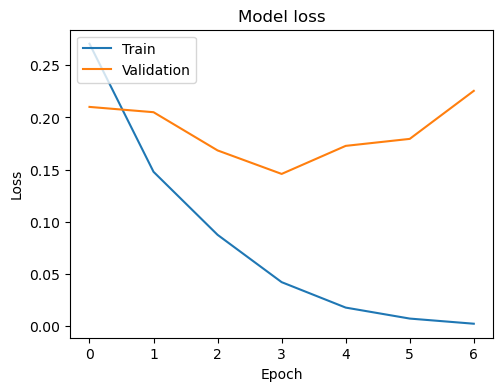

In [56]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [57]:
# Model evaluation
model.evaluate(X_test, y_test)

2036/2036 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.9519 - loss: 0.1435


[0.1401546746492386, 0.9527552723884583]

2036/2036 ━━━━━━━━━━━━━━━━━━━━ 57s 28ms/step
Confusion Matrix:
[[ 7471  1040]
 [ 2037 54581]]


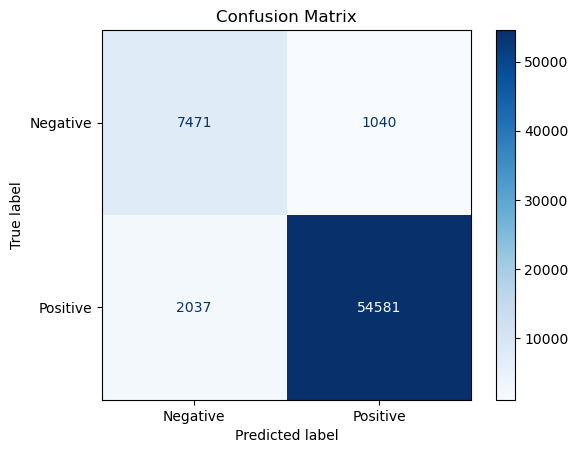

Test Accuracy: 0.95
Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.88      0.83      8511
    Positive       0.98      0.96      0.97     56618

    accuracy                           0.95     65129
   macro avg       0.88      0.92      0.90     65129
weighted avg       0.96      0.95      0.95     65129



In [95]:
# Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
test_acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_acc:.2f}')
print("Test Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
